### Mustafa Kutay Yabas - EC581 - 29.10.2016
# Assignment #3

We will test two trading strategies based on return runs.
- Trend Following Strategy
    - Buy after n days of positive return
    - Sell after m days of negative return
- Mean Reversion Strategy
    - Buy after n days of negative return
    - Sell after m days of positive return

### Steps
1. Apply two different trading algo for these strategies in quantstrat
2. Apply these strategies to BIST100 index data
3. For each strategy, optimize n and m using a grid search over set 1,2,...,10
4. Compare optimized versions of these two strategies
5. Is it better to be a trend-follower or a contrarian in BIST

In [1]:
# load libraries
library(quantstrat)
library(Quandl)

Loading required package: quantmod
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.
Loading required package: blotter
Loading required package: FinancialInstrument
Loading required package: PerformanceAnalytics

Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend

Loading required package: foreach


In [2]:
# define instruments
currency("USD")
stock("BIST", currency="USD", multiplier=1)

# get data
date_from = "2005-08-01"
date_to = "2016-05-25"

BIST<-Quandl("GOOG/INDEXIST_XU100", type="xts", start_date = date_from, end_date = date_to)
BIST<-na.omit(BIST)
BIST<-xts(coredata(BIST), as.POSIXct(time(BIST)))

[1] "USD"

[1] "BIST"

In [3]:
# define strategy component names
portfolio_name = "investiphi"

#strategy_trend = "trend_following"
strategy.st = "consecutive_days"

#account_trend = "account_trend"
account_name = "account_name"

# remove if defined before
rm.strat(portfolio_name)

#rm.strat(strategy_trend)
rm.strat(strategy.st)

#rm.strat(account_trend)
rm.strat(account_name)

# create .blotter and .strategy environments
.blotter<-new.env()
.strategy<-new.env()

# init portfolio and accoiunt in .blotter
init_eq <- 100000 # 100k
init_date <- as.character(as.Date(date_from) - 1)

initPortf(portfolio_name, symbols="BIST", initDate=init_date, currency="USD")

#initAcct(account_trend, portfolios=portfolio_name, initDate=init_date, currency="USD", initEq = init_eq)
initAcct(account_name, portfolios=portfolio_name, initDate=init_date, currency="USD", initEq = init_eq)

initOrders(portfolio_name, initDate=init_date)

[1] "investiphi"

[1] "account_name"

In [4]:
# init strategies
#strategy(strategy_trend, store=TRUE)
strategy(strategy.st, store=TRUE)

In [5]:
# you can see whats inside
temp <- get("USD", envir=FinancialInstrument:::.instrument)
summary(temp)

            Length Class  Mode     
primary_id  1      -none- character
currency    1      -none- character
multiplier  1      -none- numeric  
tick_size   1      -none- numeric  
identifiers 0      -none- list     
type        1      -none- character

In [6]:
consecutive_days<-function(days_pos,days_neg, stock, posneg = TRUE) {
    #days_pos <- 4
    #days_neg <- 4

    #n_day_signals <- data.frame(positive = logical(length(time(stock))), negative = logical(length(time(stock))))
    n_day_signals <- data.frame(sigcol = logical(length(time(stock))))
    n_day_signals <- xts( n_day_signals, as.POSIXct(time(stock)) )
    n_day_signals[1,1] <- NA

    #Signal <- xts(c("Positive", "Negative"), as.POSIXct(time(BIST)))

    sign_counter <- 1
    sign_last <- -1
    for (i in 2:length(time(stock))) {

        sign_temp <- sign( as.numeric ( as.numeric( stock[i,4]) - as.numeric( stock[i-1,4]) ) )

        if (sign_temp == sign_last) {
            sign_counter <- sign_counter + 1
        } else {
            sign_counter <- 1
            sign_last <- sign_temp
        }

        if (posneg) {
            
            if (sign_counter == days_pos && sign_last == 1) {
                n_day_signals[i,1] <- TRUE
            } else {
                n_day_signals[i,1] <- NA
            }
            
        } else {

            if (sign_counter == days_neg && sign_last == -1) {
                n_day_signals[i,1] <- TRUE
            } else {
                n_day_signals[i,1] <- NA
            }
        }
    }
    
    if (posneg == TRUE) {
        return( n_day_signals$sigcol) 
    } else {
        return(n_day_signals$sigcol)
    }

}

In [7]:
add.signal(strategy.st, name="consecutive_days",
           arguments = list(days_pos = 6, days_neg = 6, stock=BIST, posneg=TRUE),
           label="bull"
          )

add.signal(strategy.st, name="consecutive_days",
           arguments = list(days_pos = 6, days_neg = 6, stock=BIST, posneg=FALSE),
           label="bear"
          )

[1] "consecutive_days"

[1] "consecutive_days"

In [8]:
order_qty = 1

In [9]:
add.rule(strategy.st, name='ruleSignal',
         arguments=list(sigcol='sigcol.bear',
                        sigval=1,
                        orderside='short',
                        ordertype='market',
                        orderqty=-order_qty,
                        TxnFees=0,
                        replace=FALSE),
         type='enter',
         label='EnterShort'
        )

add.rule(strategy.st, name='ruleSignal',
         arguments=list(sigcol='sigcol.bull',
                        sigval=1,
                        orderside='long',
                        ordertype='market',
                        orderqty='all',
                        TxnFees=0,
                        replace=TRUE),
         type='exit',
         label='Exit2Long'
        )

[1] "consecutive_days"

[1] "consecutive_days"

In [10]:
add.rule(strategy.st, name='ruleSignal',
         arguments=list(sigcol='sigcol.bull',
                        sigval=TRUE,
                        orderside='long',
                        ordertype='market',
                        orderqty=order_qty,
                        TxnFees=0,
                        replace=FALSE),
         type='enter',
         label='EnterLong'
        )

add.rule(strategy.st, name='ruleSignal',
         arguments=list(sigcol='sigcol.bear',
                        sigval=TRUE,
                        orderside='short',
                        ordertype='market',
                        orderqty='all',
                        TxnFees=0,
                        replace=TRUE),
         type='exit',
         label='Exit2Short'
        )

[1] "consecutive_days"

[1] "consecutive_days"

In [11]:
summary(get("consecutive_days", envir=.strategy))

            Length Class  Mode     
name        1      -none- character
assets      0      -none- NULL     
indicators  0      -none- list     
signals     2      -none- list     
rules       3      -none- list     
constraints 0      -none- NULL     
init        0      -none- list     
wrapup      0      -none- list     
call        3      -none- call     

In [12]:
# apply strategy
applyStrategy(strategy.st, portfolio_name)

[1] "2005-08-15 03:00:00 BIST -1 @ 28074.94"
[1] "2005-08-26 03:00:00 BIST 1 @ 30020.4"
[1] "2005-11-22 02:00:00 BIST 1 @ 35254.14"
[1] "2006-01-17 02:00:00 BIST -1 @ 44076.91"
[1] "2006-01-17 02:00:00 BIST 1 @ 44076.91"
[1] "2006-04-26 03:00:00 BIST -1 @ 44745.54"
[1] "2006-04-26 03:00:00 BIST 1 @ 44745.54"
[1] "2006-06-13 03:00:00 BIST -1 @ 32384.42"
[1] "2006-07-05 03:00:00 BIST 1 @ 35385.02"
[1] "2006-07-18 03:00:00 BIST -1 @ 33617.96"
[1] "2006-08-25 03:00:00 BIST -1 @ 36861.66"
[1] "2006-10-17 03:00:00 BIST 1 @ 38456.75"
[1] "2007-01-11 02:00:00 BIST -1 @ 37640.38"
[1] "2007-05-24 03:00:00 BIST 1 @ 46237.07"
[1] "2007-07-06 03:00:00 BIST 1 @ 49895.33"
[1] "2008-01-17 02:00:00 BIST -1 @ 48902.75"
[1] "2008-05-27 03:00:00 BIST -1 @ 40189.29"
[1] "2008-08-05 03:00:00 BIST 1 @ 42237.75"
[1] "2008-09-17 03:00:00 BIST -1 @ 32727.57"
[1] "2008-11-05 02:00:00 BIST 1 @ 27855.92"
[1] "2009-03-26 02:00:00 BIST 1 @ 25409.83"
[1] "2009-07-02 03:00:00 BIST -1 @ 37038.21"
[1] "2009-07-02 03:00:

In [13]:
# update portfolio
updatePortf(portfolio_name)
updateAcct(account_name)
updateEndEq(account_name)

[1] "investiphi"

[1] "account_name"

[1] "account_name"

In [14]:
OB<-getOrderBook(portfolio_name)

In [15]:
getEndEq(account_name, date_to)

[1] 159678.6

In [16]:
OB$investiphi$BIST

                    Order.Qty Order.Price Order.Type Order.Side Order.Threshold
2005-08-12 03:00:00 "-1"      "28175.93"  "market"   "short"    NA             
2005-08-25 03:00:00 "all"     "29814.17"  "market"   "long"     NA             
2005-08-25 03:00:00 "1"       "29814.17"  "market"   "long"     NA             
2005-11-21 02:00:00 "1"       "35654.99"  "market"   "long"     NA             
2006-01-16 02:00:00 "all"     "43628.83"  "market"   "long"     NA             
2006-01-16 02:00:00 "1"       "43628.83"  "market"   "long"     NA             
2006-04-25 03:00:00 "all"     "45352.51"  "market"   "long"     NA             
2006-04-25 03:00:00 "1"       "45352.51"  "market"   "long"     NA             
2006-06-12 03:00:00 "all"     "34330.32"  "market"   "short"    NA             
2006-06-12 03:00:00 "-1"      "34330.32"  "market"   "short"    NA             
2006-07-04 03:00:00 "1"       "36481.23"  "market"   "long"     NA             
2006-07-17 03:00:00 "all"     "32702.89"

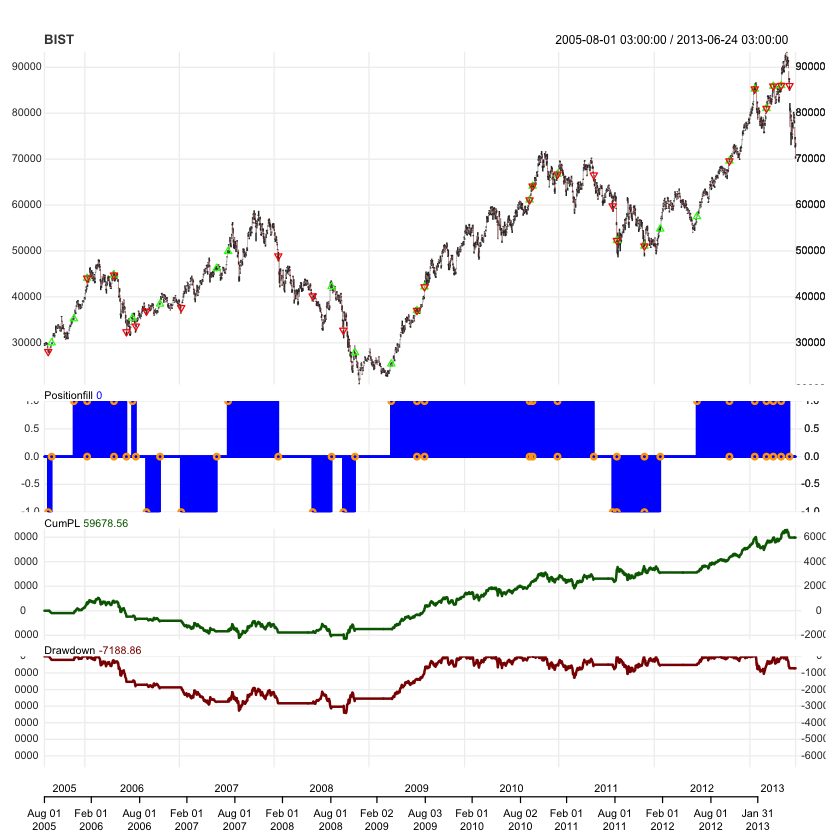

In [17]:
chart.Posn(portfolio_name, "BIST")